In [292]:
#### If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

#data analysis libs
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind, wilcoxon, f_oneway
from matplotlib import pyplot as plt, ticker
from statannot import add_stat_annotation
from tqdm import tqdm
import seaborn as sns
sns.set_theme(font_scale=1.8)

#bioinf libs
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting
import pyranges as pr
import gffpandas.gffpandas as gffpd
import gseapy
from gseapy import barplot, dotplot

#common libs
from glob import glob
import json
from os.path import basename, splitext
from importlib import reload
from natsort import natsorted, natsort_keygen
import pickle
import logging
logging.getLogger().disabled = True

#my stuff
import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
from utils.statistics import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

In [129]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/coolers'
MERGED_COOLER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_coolers'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
MERGED_DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
TAD_PATH = '/tank/projects/kriukov_chromatin/HIC/tads'
LOOP_PATH = '/tank/projects/kriukov_chromatin/HIC/loops'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'
EXPRESSION_PATH = '/tank/projects/kriukov_chromatin/RNA'
EXPECTED_PATH = '/tank/projects/kriukov_chromatin/HIC/expected'

In [3]:
#import genes
gffpath = '%s/Mus_musculus.GRCm38.102.chr.gff3' % GENOME_FOLDER_PATH
annotation = gffpd.read_gff3(gffpath)
#annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
#fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
#refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
#gn.seq_id = gn.seq_id.map(refseq2chrom)
gn.seq_id = 'chr' + gn.seq_id.astype('str')
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length']]
gn['Name'] = gn['Name'].str.upper()
#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/gffpandas/gffpandas.py:21: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  self._read_gff3_to_df()


In [4]:
RESOLUTION = 50_000
downsampled = True
merged = True

if downsampled:
    if merged:
        FILES = natsorted(glob('%s/*2000.mcool' % (MERGED_DOWNSAMPLED_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = [basename(c.filename).split('_')[0] for c in CLRS]
    else:
        FILES = natsorted(glob('%s/*2000.mcool' % (DOWNSAMPLED_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = ['_'.join(basename(c.filename).split('_')[:3]) for c in CLRS]
else:
    if merged:
        FILES = natsorted(glob('%s/*.mcool' % (MERGED_COOLER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = [basename(c.filename).split('.')[0] for c in CLRS]
    else:
        FILES = natsorted(glob('%s/*.mcool' % (COOLER_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = ['_'.join(basename(c.filename).split('_')[:3]).split('.')[0] for c in CLRS]

[print(c, '\t', l) for c, l in zip(CLRS, LBLS)];
CLRS_dict = dict(zip(LBLS, CLRS))

#compartments
if merged:
    eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/*_down_no_2_diag_50000*lam.txt'))
    eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/*_down_no_2_diag_50000*vecs.txt'))
    eigvec = {l:pd.read_csv(f, sep='\t') \
              for l, f in zip(['KO', 'adl', 'old', 'yng'], eigvec_files)}
    eigval = {l:pd.read_csv(f, sep='\t', index_col=1) \
                for l, f in zip(['KO', 'adl', 'old', 'yng'], eigval_files)}
else:
    eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/*lam.txt'))
    eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/*vecs.txt'))
    eigvec = {l:pd.read_csv(f, sep='\t') \
              for l, f in zip(['KO', 'adl', 'old', 'yng'], eigvec_files)}
    eigval = {l:pd.read_csv(f, sep='\t', index_col=1) \
                for l, f in zip(['KO', 'adl', 'old', 'yng'], eigval_files)}

#insulation score
if merged:
    IS = pd.read_csv('%s/IS_merged_new_50000.csv' % INSULATION_PATH, index_col=0)
else:
    #IS = pd.read_csv('%s/IS_25000.csv' % INSULATION_PATH, index_col=0)
    IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

#TADs
TADS = json.load(open(TAD_PATH + '/' + 'lavaburst_tads_arkuda.json', 'r'))

#diffexpressed genes
slopes = pd.read_csv('subdata/diffexp_result.csv', index_col=0)
pbulk_full = pd.read_csv('subdata/DE_results_GSE129788_old::young.csv', index_col=0)
pbulk_neur = pd.read_csv('subdata/DE_results_GSE129788_old::young_mNeur.csv', index_col=0)
sc_neur =  pd.read_csv('subdata/scDE_results_GSE129788_old::young.csv', index_col=0)
sc_neur['gene'] = sc_neur['gene'].str.upper()

#gene sets
gene_sets = json.load(open('subdata/genesets/age_gene_set.gmt', 'r'))

#List of neuron specific genes
min_gene_length = 0
de_genes = sc_neur[(sc_neur.qval < 1e-3)]
sc_neur_filt = sc_neur.merge(gn_code[['Name', 'seq_id', 'start', 'end']], left_on='gene', right_on='Name')
#size filter
universe_neur_list = sc_neur_filt[sc_neur_filt['mean'] >= de_genes['mean'].min()].gene.tolist()
universe_neur_list = list(map(str.upper, universe_neur_list))
print('Universe size:', len(universe_neur_list))


#snp profiles 
snp_profiles = pd.read_csv('subdata/snp_profiles.csv', index_col=0)
snp_merged = snp_profiles.copy()
snp_merged['adl'] = snp_profiles.filter(regex='WT').sum(1)
snp_merged['yng'] = snp_profiles.filter(regex='young').sum(1)
snp_merged['old'] = snp_profiles.filter(regex='old').sum(1)
snp_merged = snp_merged[['chrom', 'start', 'yng', 'adl', 'old']]

#view and chromsizes
mm10_arms = pd.read_csv('subdata/mm10_view.bed', sep='\t', names=['chrom', 'start', 'end', 'name'])
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
mm10_chromsizes = CLRS[0].chromsizes

#load scalings
scalings_data = pickle.load(open(EXPECTED_PATH + 'cis_scaling_50000.pkl', 'rb'))
trans_data = pickle.load(open(EXPECTED_PATH + 'trans_scaling_50000.pkl', 'rb'))

<Cooler "KO_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 KO
<Cooler "adl_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 adl
<Cooler "old_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 old
<Cooler "yng_down_no_2_diag.2000.mcool::/resolutions/50000"> 	 yng


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Universe size: 11251


In [248]:
scalings_data = pickle.load(open(EXPECTED_PATH + 'cis_scaling_50000_mod.pkl', 'rb'))
trans_data = pickle.load(open(EXPECTED_PATH + 'trans_scaling_50000_mod.pkl', 'rb'))

## Prepare expected data

In [232]:
def make_expected_stats_cis(cooler, chroms, balance=True):
    """ My edition
    """
    df = pd.DataFrame()
    for chrom in tqdm(chroms):
        mat = cooler.matrix(balance=balance, sparse=True).fetch(chrom)
        n = mat.shape[0]
        for i in range(n):
            arr = mat.diagonal(i)
            df = df.append({'chr':chrom,
                            'dist':i,
                            'avg':np.nanmean(arr), 
                            'std':np.nanstd(arr), 
                            'n':arr.shape[0]}, ignore_index=True)
    return df

def make_expected_stats_trans(cooler, chroms, balance=True):
    """ My edition
        TODO: solve problem of .todense() - it's awful!
    """
    df = pd.DataFrame()
    for i, c1 in enumerate(chroms):
        for j, c2 in enumerate(chroms[i:], start=i):
            mat = cooler.matrix(balance=balance, sparse=True).fetch(c1, c2)
            arr = mat.todense().ravel()
            df = df.append({'chr1':c1,
                            'chr2':c2,
                            'avg':np.nanmean(arr), 
                            'std':np.nanstd(arr),
                            'n':arr.shape[0]}, ignore_index=True)
    return df

In [233]:
cis_stats = {}
trans_stats = {}
for k, clr in CLRS_dict.items():
    cis_stats[k] = make_expected_stats(clr, chroms=clr.chromnames, balance=False)
    trans_stats[k] = make_expected_stats_trans(clr, chroms=clr.chromnames, balance=False)

100%|███████████████████████████████████████████| 21/21 [06:58<00:00, 19.93s/it]


In [244]:
scalings_data_new
trans_data_new = {}
for k in CLRS_dict.keys():
    scalings_data_new[k] = scalings_data[k].merge(cis_stats[k], 
                                              left_on=['region2', 'dist'],
                                              right_on=['chr', 'dist'])
    trans_data_new[k] = trans_data[k].merge(trans_stats[k], 
                              left_on=['region1', 'region2'],
                              right_on=['chr1', 'chr2'])

In [247]:
pickle.dump(trans_data_new, open(EXPECTED_PATH + 'trans_scaling_50000_mod.pkl', 'wb'))
pickle.dump(scalings_data_new, open(EXPECTED_PATH + 'cis_scaling_50000_mod.pkl', 'wb'))

In [141]:
#construct scalings
# scalings_data = {}
# trans_data = {}
# ignore_diags = 2
# for cond, clr in zip(LBLS, CLRS):
#     # Calculate expected interactions for chromosome arms
#     expected = expected_cis(clr, view_df=None,
#                             chunksize=1000000, nproc=18,
#                             smooth=True, aggregate_smoothed=True, 
#                             smooth_sigma=0.1,
#                             ignore_diags=ignore_diags)
#     trans = expected_trans(clr, view_df=None,
#                            chunksize=1000000, nproc=18,
#                            # full chromosomes as the view
#                             )
#     scalings_data[cond] = expected
#     trans_data[cond] = trans

# pickle.dump(scalings_data, open(EXPECTED_PATH + 'cis_scaling_50000.pkl', 'wb'))
# pickle.dump(trans_data, open(EXPECTED_PATH + 'trans_scaling_50000.pkl', 'wb'))

## run analysis

In [373]:
#sample based
#arguments
genes = gn_code.sample(10, random_state=330)
# genes = gn_code[gn_code['Name'].isin(['ADCY5', 'HTT', 'AKT1', 'AKT2', 'CDKN1A'])]
print(genes['length'].mean())
genes = genes.sort_values('seq_id', key=natsort_keygen())
genes

18263.1


,seq_id,source,type,start,end,score,strand,ID,Name,description,length
36042,chr1,havana,gene,36710149,36757953,.,+,gene:ENSMUSG00000102416,4933424G06RIK,RIKEN cDNA 4933424G06 gene [Source:MGI Symbol%...,47804
2020262,chr2,ensembl_havana,gene,89991221,89996189,.,+,gene:ENSMUSG00000061295,OLFR1261,olfactory receptor 1261 [Source:MGI Symbol%3BA...,4968
2042583,chr2,ensembl_havana,gene,104027721,104063240,.,+,gene:ENSMUSG00000027180,FBXO3,F-box protein 3 [Source:MGI Symbol%3BAcc:MGI:1...,35519
2703758,chr5,havana,gene,65405751,65406517,.,+,gene:ENSMUSG00000106291,1110003F10RIK,RIKEN cDNA 1110003F10 gene [Source:MGI Symbol%...,766
2923103,chr6,ensembl_havana,gene,48718621,48724636,.,+,gene:ENSMUSG00000043931,GIMAP7,GTPase%2C IMAP family member 7 [Source:MGI Sym...,6015
539336,chr11,ensembl_havana,gene,60469339,60528369,.,+,gene:ENSMUSG00000042678,MYO15,myosin XV [Source:MGI Symbol%3BAcc:MGI:1261811],59030
564509,chr11,ensembl_havana,gene,70054085,70057894,.,+,gene:ENSMUSG00000020884,ASGR1,asialoglycoprotein receptor 1 [Source:MGI Symb...,3809
567542,chr11,ensembl_havana,gene,70651850,70654644,.,-,gene:ENSMUSG00000018293,PFN1,profilin 1 [Source:MGI Symbol%3BAcc:MGI:97549],2794
920114,chr13,ensembl_havana,gene,50417864,50433780,.,+,gene:ENSMUSG00000037816,FBXW17,F-box and WD-40 domain protein 17 [Source:MGI ...,15916
1562129,chr17,ensembl_havana,gene,35910379,35916389,.,-,gene:ENSMUSG00000024436,MRPS18B,mitochondrial ribosomal protein S18B [Source:M...,6010


In [381]:
#term based
#term = 'GO_Biological_Process_2021:::regulation of neuron projection development (GO:0010975)'
#term = 'GO_Biological_Process_2021:::neuron projection morphogenesis (GO:0048812)'
#term = 'GO_Biological_Process_2021:::modulation of chemical synaptic transmission (GO:0050804)'
term = 'KEGG_2019_Mouse:::Gap junction'
term_genes_list = gene_sets[term]
print(len(term_genes_list))
genes = gn_code[gn_code['Name'].isin(term_genes_list)]

86


In [364]:
#expression based
upreg = sc_neur[(sc_neur.qval < 0.01) & (sc_neur.log2fc > 0.2)]
dwreg = sc_neur[(sc_neur.qval < 0.01) & (sc_neur.log2fc < -0.2)]
print(f'Up:{upreg.shape[0]}, Dw:{dwreg.shape[0]}')
upreg_genes = gn_code[gn_code['Name'].isin(upreg['gene'].tolist())]
dwreg_genes = gn_code[gn_code['Name'].isin(dwreg['gene'].tolist())]

genes = upreg_genes.copy()

Up:82, Dw:183


In [382]:
genes = genes[(genes['length'] < 50_000) & (genes['length'] > 10_000)]
print(len(genes))

25


In [366]:
def get_gene_pixels(clr, genes,
                    cis_exp=None,
                    trans_exp=None,
                    balance=False, 
                    ignore_diags=2,
                    return_type='genes'): #may be gene list to input is better (not dataframe)
    """
    Function returns submatrix of Hi-C matrix with pixels 
    corresponding only the genes in the given list.
    """
    #expected_column = 'count.avg' if balance else 'balanced.avg'
    expected_column = 'avg'
    sigma_column = 'std'
    bins = clr.bins()[:].iloc[:, :3]
    gb = bins_to_genes_intersection(bins, genes)
    gb = bins.reset_index().merge(gb, 
                             left_on=['chrom', 'start', 'end'], 
                             right_on=['Chromosome', 'Start_b', 'End_b'])
    idx = gb['index'].copy().tolist()
    chroms = gb['chrom'].tolist()
    clmat = clr.matrix(balance=balance)
    mat = np.zeros((len(idx), len(idx)))
    pval = np.ones((len(idx), len(idx)))
    for i, (ix1, chr1) in tqdm(enumerate(zip(idx, chroms))):
        #for j, (ix2, chr2) in enumerate(zip(idx, chroms)):
        for j, (ix2, chr2) in enumerate(zip(idx[i:], chroms[i:]), start=i):
            dist = abs(i - j)
            if dist < ignore_diags:
                mat[i, j] = 0
            else:
                x = clmat[ix1, ix2] #retrieve value from the matrix
                if chr1 == chr2: 
                    #cis contact
                    if (cis_exp is not None) and (trans_exp is not None):
                        avg, std = cis_exp[(cis_exp['region1']==chr1) & 
                                           (cis_exp['dist']==dist)][[expected_column, 
                                                                 sigma_column]].values[0]
                        pval[i, j] = pval[j, i] = binomial_test(x, avg, std)
                    else: 
                        avg, std = (1, 1)
                else: 
                    #trans contact
                    if (cis_exp is not None) and (trans_exp is not None):
                        avg, std = trans_exp[(trans_exp['region1']==chr1) & 
                                             (trans_exp['region2']==chr2)][[expected_column, 
                                                                        sigma_column]].values[0]
                        pval[i, j] = pval[j, i] = binomial_test(x, avg, std)
                    else:
                        avg = 1
                mat[i, j] = mat[j, i] = x / avg # fill matrix with OE values
                    
    if return_type=='genes':
        mat = pd.DataFrame(mat, index=gb['Name'], columns=gb['Name'])
        pval = pd.DataFrame(pval, index=gb['Name'], columns=gb['Name'])
    elif return_type=='intervals':
        pass
    return mat, pval

35it [00:01, 18.64it/s]
35it [00:01, 19.54it/s]


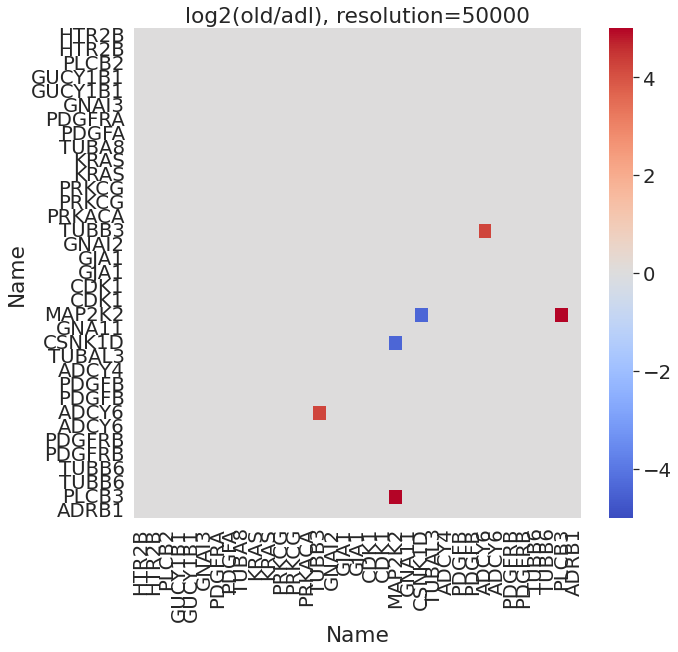

In [384]:
thr = 3 # corresponds to p-value ratio = 0.03
balance = False
pairs = [('old', 'adl'), 
         #('adl', 'yng')
        ]

for pair in pairs:
    clr_nom = CLRS_dict[pair[0]]
    clr_den = CLRS_dict[pair[1]]
    mat_nom, pv_nom = get_gene_pixels(clr_nom, genes, #older
                           cis_exp=scalings_data[pair[0]], 
                           trans_exp=trans_data[pair[0]], 
                           balance=balance)
    mat_den, pv_den = get_gene_pixels(clr_den, genes, #younger
                           cis_exp=scalings_data[pair[1]], 
                           trans_exp=trans_data[pair[1]], 
                           balance=balance)
    
    div = -np.log10(pv_nom / pv_den)
    div[np.abs(div) < thr] = 0

    #plotting
    fig, ax = plt.subplots(1,1, figsize=(10,9))
    sns.heatmap(div, xticklabels=True, yticklabels=True, vmin=-5, vmax=5, cmap='coolwarm', ax=ax, )
    ax.set_title(f'log2({pair[0]}/{pair[1]}), resolution={RESOLUTION}')
    plt.show()

In [394]:
div.loc[div.any(1), div.any(1)]

Name,TUBB3,MAP2K2,CSNK1D,ADCY6,PLCB3
Name,,,,,
TUBB3,0.000000,0.000000,0.000000,4.221373,0.000000
MAP2K2,0.000000,0.000000,-4.390459,0.000000,7.744619
CSNK1D,0.000000,-4.390459,0.000000,0.000000,0.000000
ADCY6,4.221373,0.000000,0.000000,0.000000,0.000000
PLCB3,0.000000,7.744619,0.000000,0.000000,0.000000


In [397]:
pv_nom.loc[div.any(1), div.any(1)]

Name,TUBB3,MAP2K2,CSNK1D,ADCY6,PLCB3
Name,,,,,
TUBB3,1.000000,1.757919e-03,0.044407,0.000002,4.137515e-02
MAP2K2,0.001758,1.000000e+00,0.002974,0.030365,7.017009e-10
CSNK1D,0.044407,2.974137e-03,1.000000,0.000052,3.706855e-03
ADCY6,0.000002,3.036488e-02,0.000052,1.000000,1.112671e-01
PLCB3,0.041375,7.017009e-10,0.003707,0.111267,1.000000e+00


In [401]:
target = ('PLCB3', 'MAP2K2')
gn_code[gn_code['Name'].isin(target)][['seq_id', 'start', 'end']]

,seq_id,start,end
379077,chr10,81105915,81133975
1784174,chr19,6952325,6976470


[[0 0 0 0 1]
 [0 0 1 1 0]
 [1 0 6 0 0]
 [2 1 2 0 0]
 [0 2 1 3 1]]


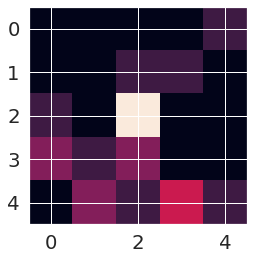

[[0 0 1 2 0]
 [1 1 1 1 1]
 [0 3 0 0 2]
 [0 1 1 0 0]
 [0 1 1 1 0]]


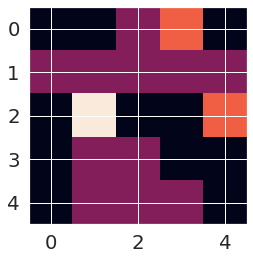

In [411]:
w = 100_000
coo1 = f'chr10:{81105915 - w}-{81133975 + w}'
coo2 = f'chr19:{6952325 - w}-{6976470 + w}'

for clr in [clr_nom, clr_den]:
    D = clr.matrix(balance=False).fetch(coo1, coo2)
    print(D)
    plt.imshow(D)
    plt.show()

#D = mylog(D, log=True)
# plot_hic_triangle(D, 
#                   vmax=6,
#                   vmin=None,
#                   savepath=None)

In [ ]:
#large scale

params = [{'res':1_000_000, 'vmax':11, 'vmin':None, 'name':'interchromosomal'},
          {'res':200_000, 'vmax':6, 'vmin':-0.5, 'coo':'chr1:2,000,000-195M', 'name':'chromosomal'},
          {'res':50_000, 'vmax':6, 'vmin':None, 'coo':'chr1:30,000,000-40,000,000', 'name':'medium'},
          {'res':50_000, 'vmax':7, 'vmin':None, 'coo':'chr1:43,000,000-47,000,000', 'name':'point'}
         ]
for i, p in enumerate(params):
    file = glob('%s/adl*.mcool' % MERGED_DOWNSAMPLED_FOLDER_PATH)[0]
    cool = clr
    if i == 0:
        st = 0
        end = cool.extent('chr4')[-1]
        D = cool.matrix(balance=False)[st:end, st:end]
    else:
        D = cool.matrix(balance=False).fetch(p['coo'])
    D = mylog(D, log=True)
    plot_hic_triangle(D, 
                      vmax=p['vmax'],
                      vmin=p['vmin'],
                      savepath='figs/hic_pyramid_miniature_%d_%s.png' % (p['res'], p['name']))

In [ ]:
###OLD VERSION
# eps = 1#1e-6
# thr = 2
# balance = False
# pairs = [('old', 'adl'), 
#         # ('adl', 'yng')
#         ]

# for pair in pairs:
#     clr_nom = CLRS_dict[pair[0]]
#     clr_den = CLRS_dict[pair[1]]
#     mat_nom, pv_nom = get_gene_pixels(clr_nom, genes, #older
#                            cis_exp=scalings_data[pair[0]], 
#                            trans_exp=trans_data[pair[0]], 
#                            balance=balance)
#     mat_den, pv_den = get_gene_pixels(clr_den, genes, #younger
#                            cis_exp=scalings_data[pair[1]], 
#                            trans_exp=trans_data[pair[1]], 
#                            balance=balance)
#     #div = np.log2((mat2 + eps) / (mat1 + eps))
#     div = -np.log10(pv_nom / pv_den)
#     div[np.abs(div) < 2] = 0

#     #plotting
#     fig, ax = plt.subplots(1,1, figsize=(7,5.5))
#     sns.heatmap(div, xticklabels=True, yticklabels=True, vmin=-5, vmax=5, cmap='coolwarm', ax=ax, )
#     ax.set_title(f'log2({pair[0]}/{pair[1]}), resolution={RESOLUTION}')
#     plt.show()

In [84]:
tmat = clr.matrix(balance=False).fetch('chr1', 'chr2')
track = tmat.ravel()
track.mean()

0.036543544603987746

In [99]:
track.mean()

0.0336195397251836

In [116]:
poisson.pmf(1, mu)

0.03249914046440936

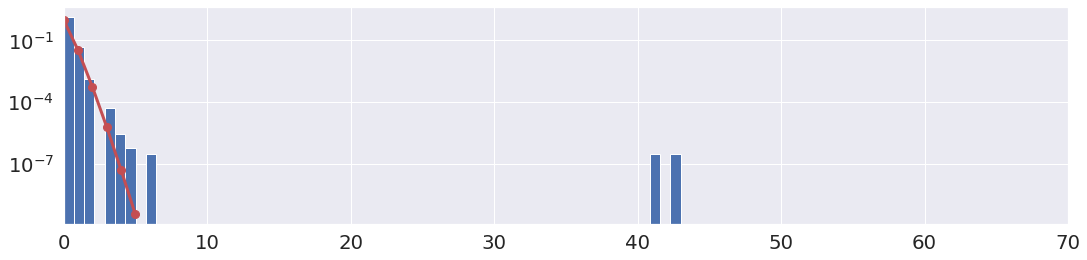

In [113]:
tmat = clr.matrix(balance=False).fetch('chr1', 'chr19')
track = tmat.ravel()

from scipy.stats import poisson

mu = 0.03361
x = np.arange(poisson.ppf(1e-5, mu),
              poisson.ppf(1 - 1e-12, mu))


plt.figure(figsize=(18,4))
plt.hist(track, bins=60, density=True)
plt.plot(x, poisson.pmf(x, mu), 'r', marker='o', lw=3, ms=8, label='poisson pmf')
plt.yscale('log')
plt.xlim([0, 70])
plt.show()


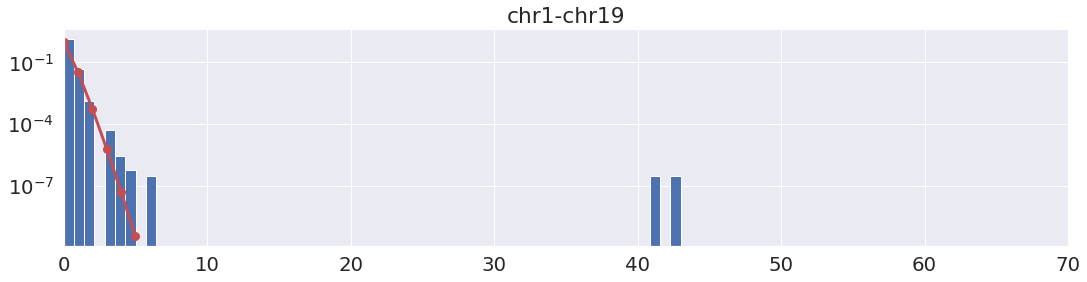

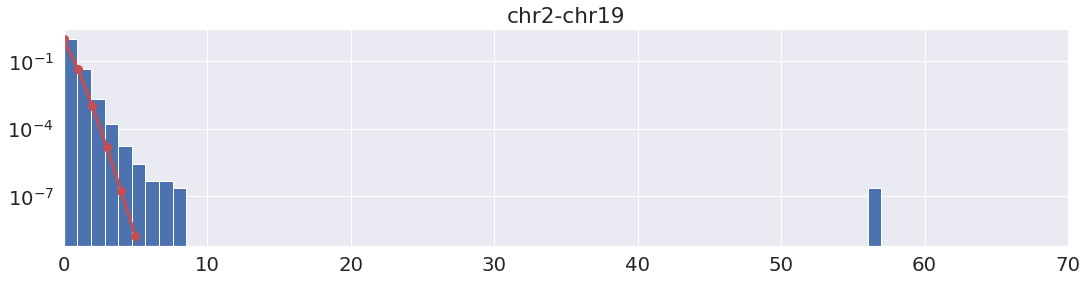

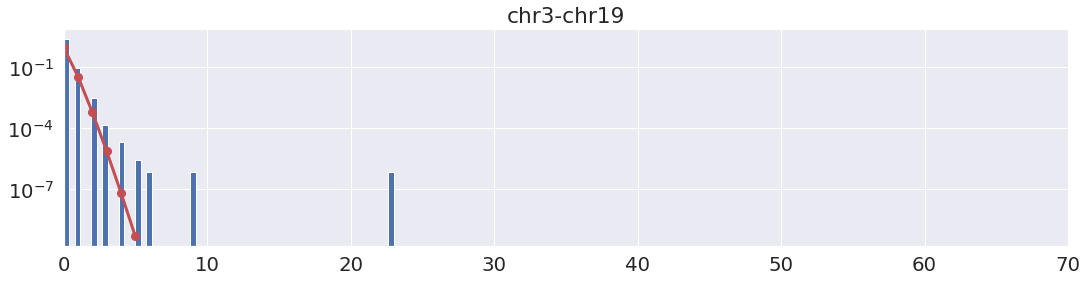

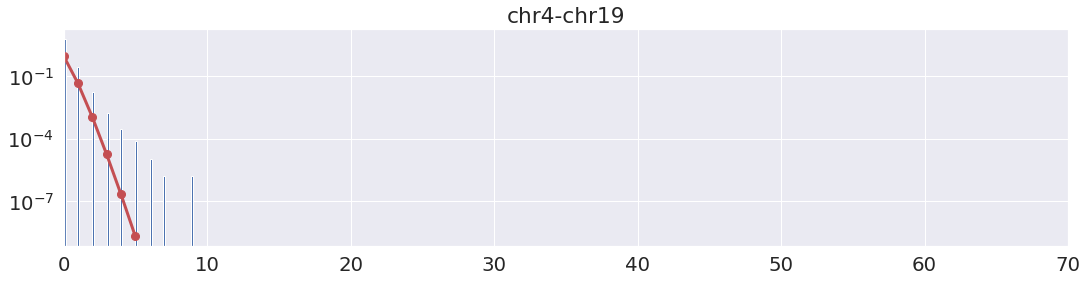

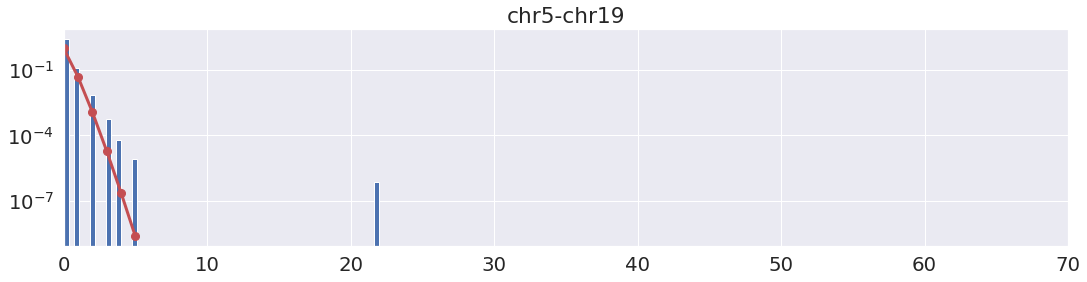

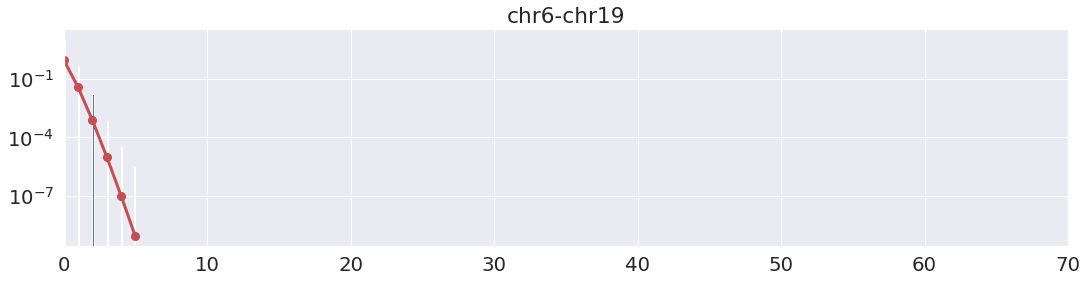

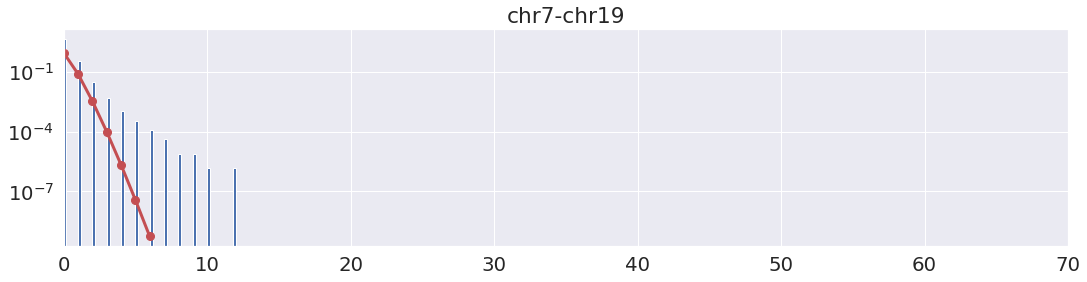

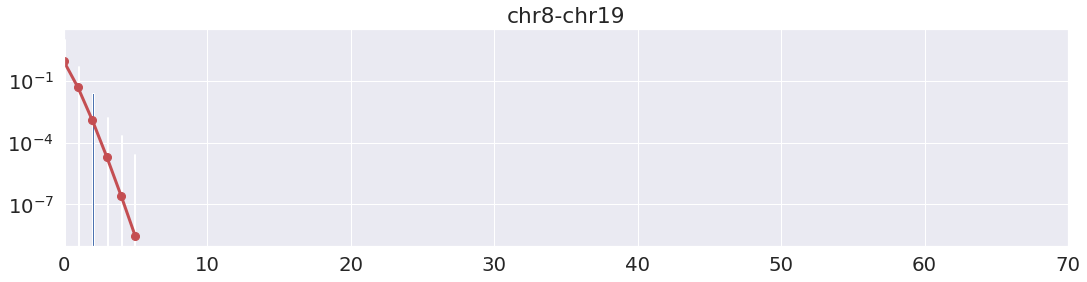

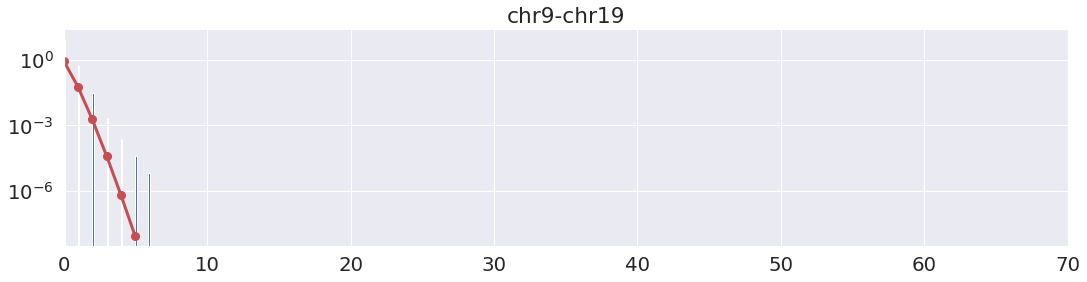

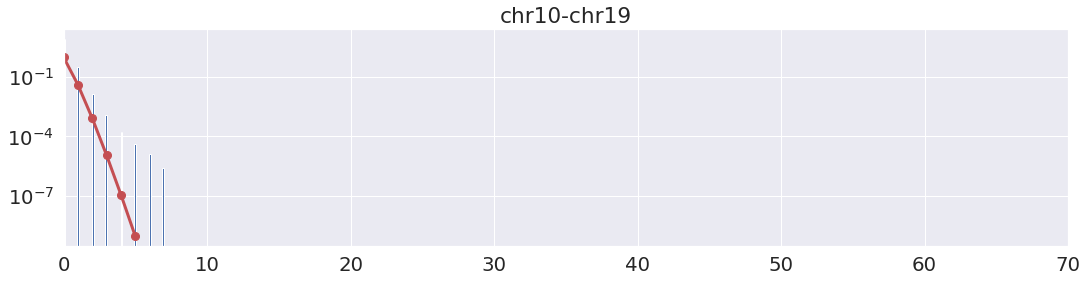

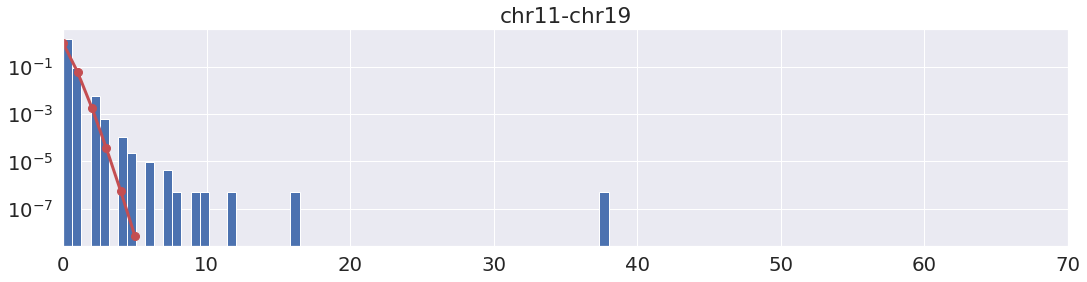

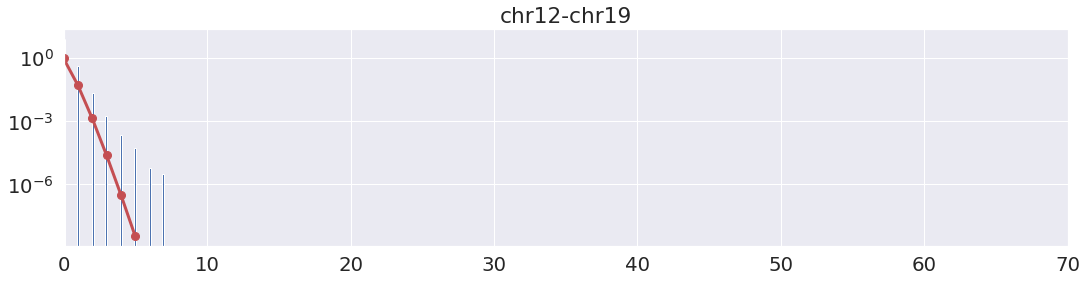

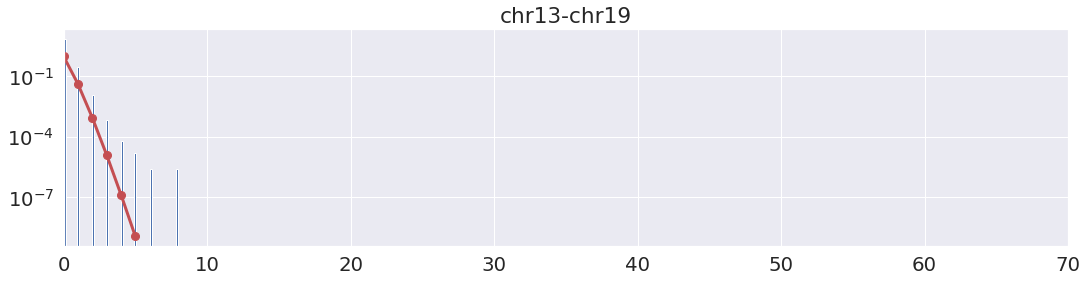

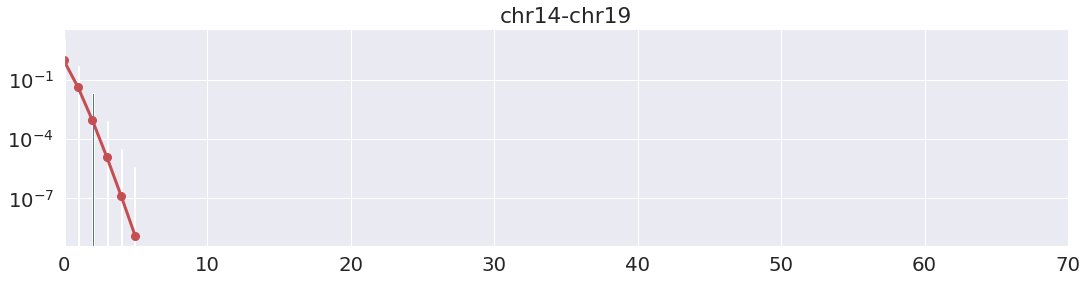

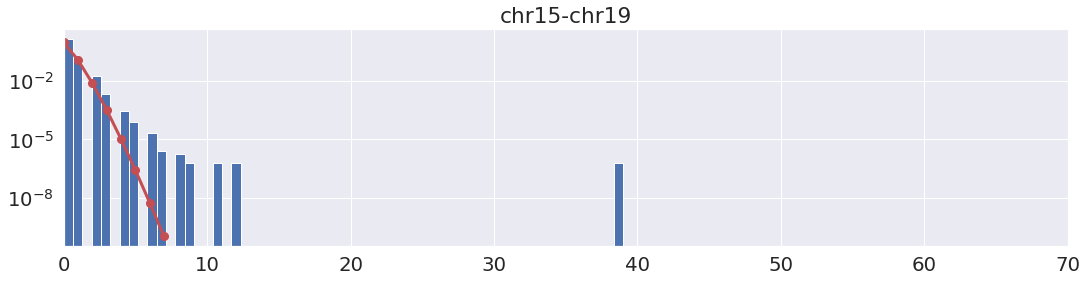

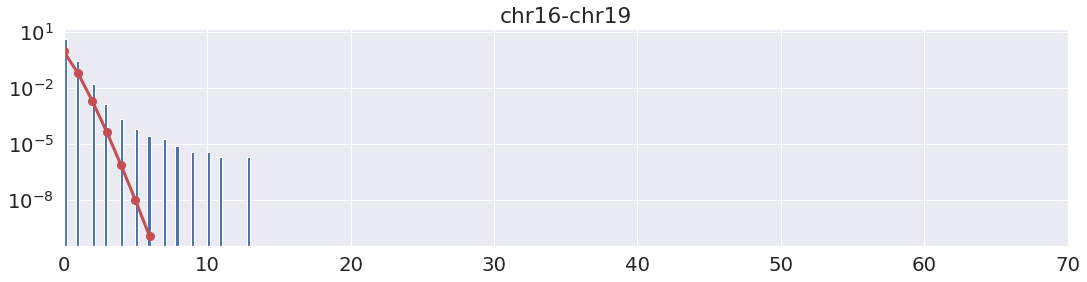

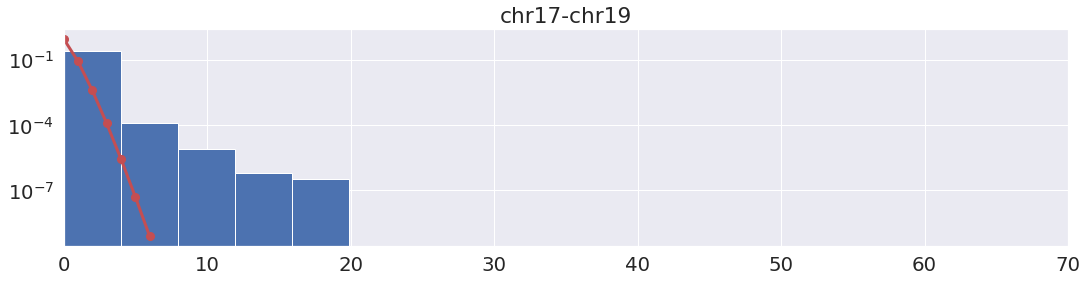

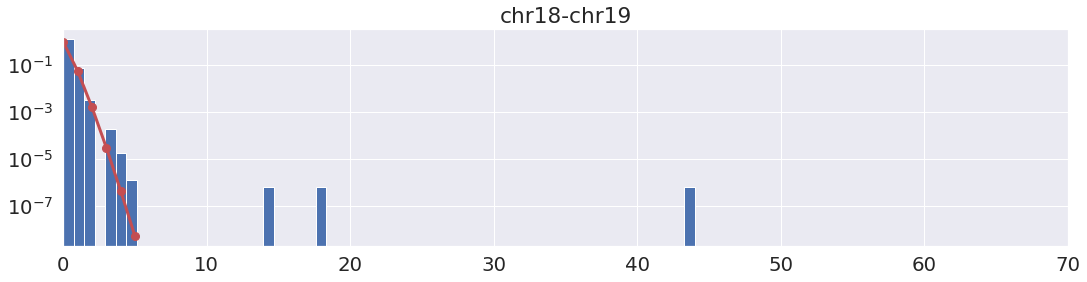

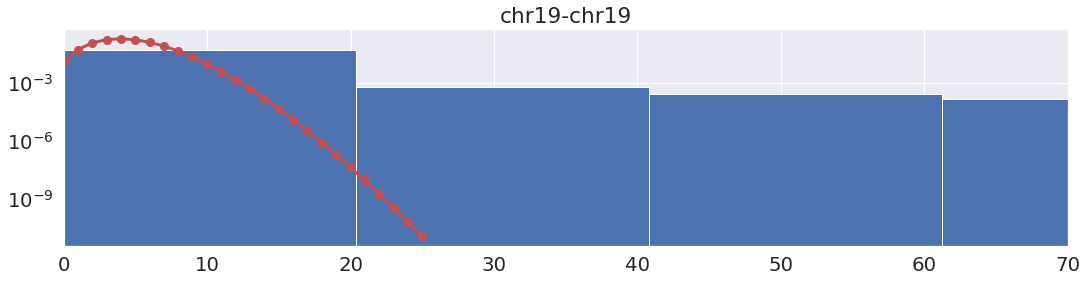

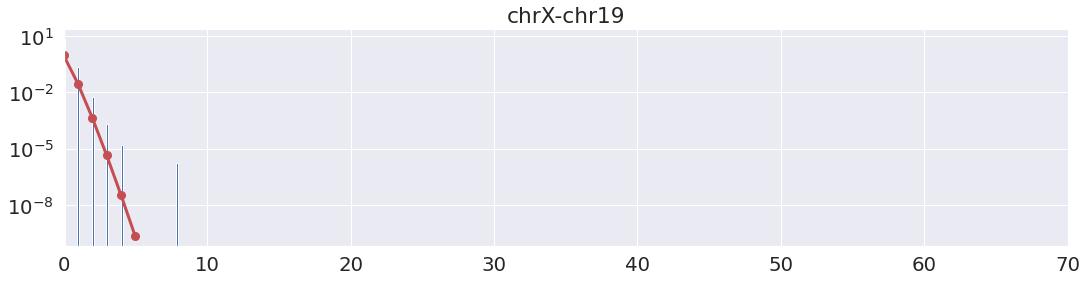

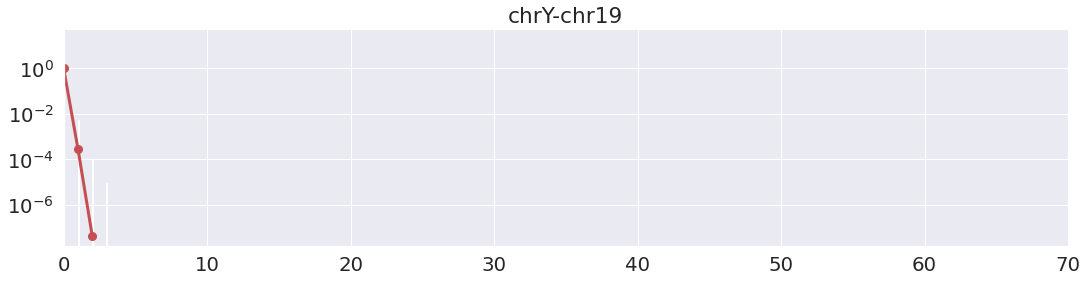

In [118]:
for c in clr.chromnames:
    tmat = clr.matrix(balance=False).fetch(c, 'chr19')
    track = tmat.ravel()
    mu = track.mean()
    x = np.arange(poisson.ppf(1e-5, mu),
                  poisson.ppf(1 - 1e-12, mu))

    plt.figure(figsize=(18,4))
    plt.title(f'{c}-chr19')
    plt.hist(track, bins=60, density=True)
    plt.plot(x, poisson.pmf(x, mu), 'r', marker='o', lw=3, ms=8, label='poisson pmf')
    plt.yscale('log')
    plt.xlim([0, 70])
    plt.show()


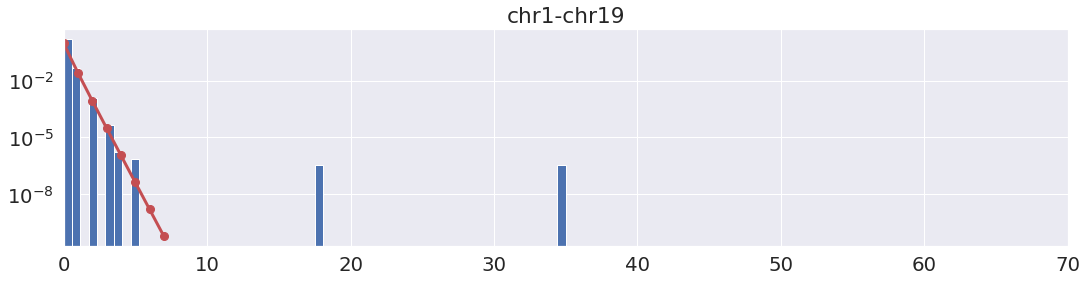

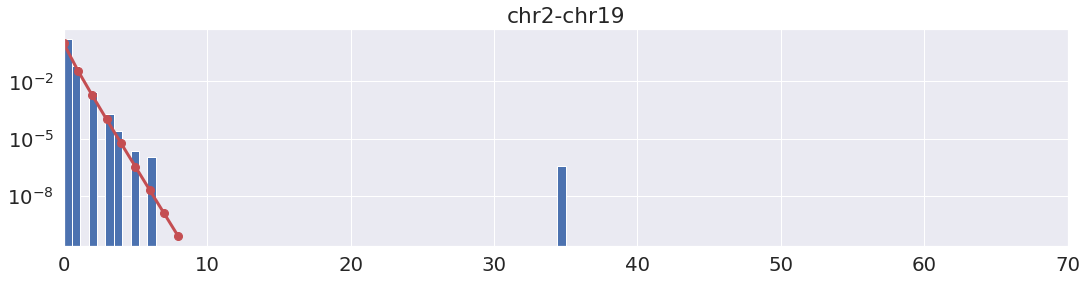

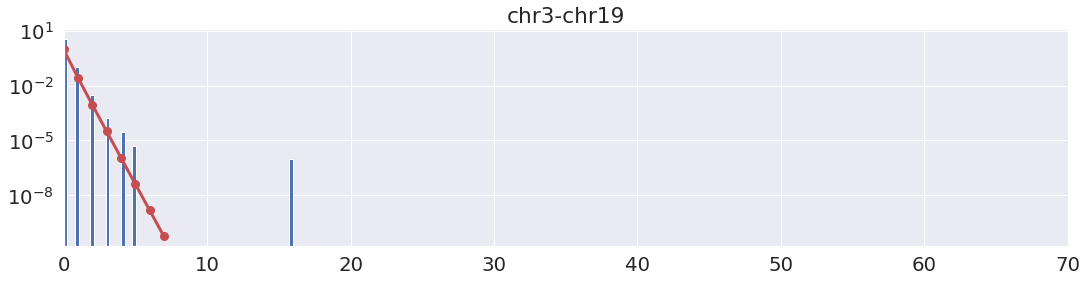

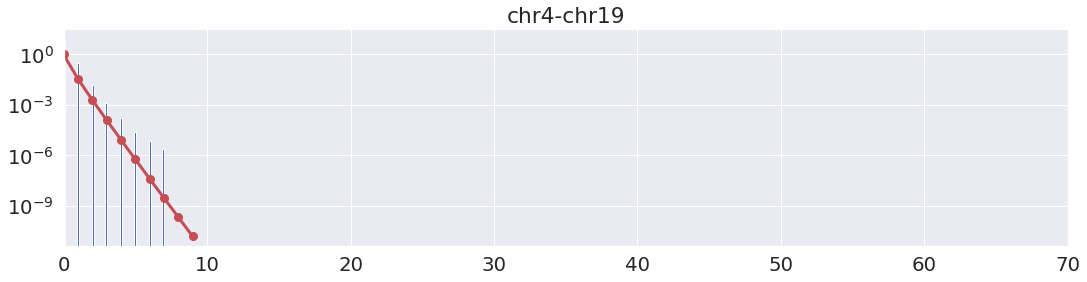

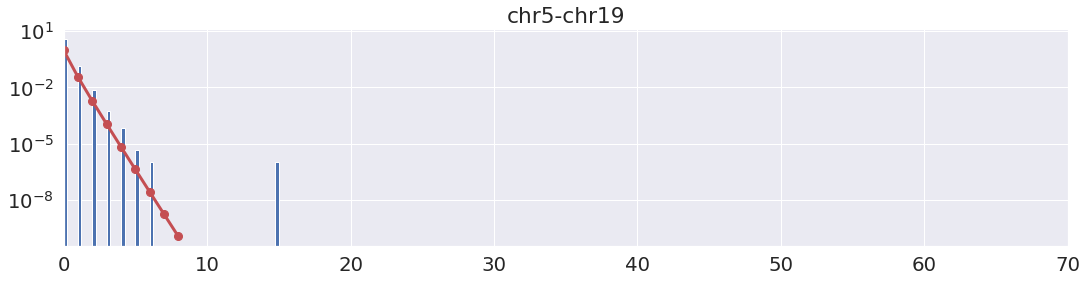

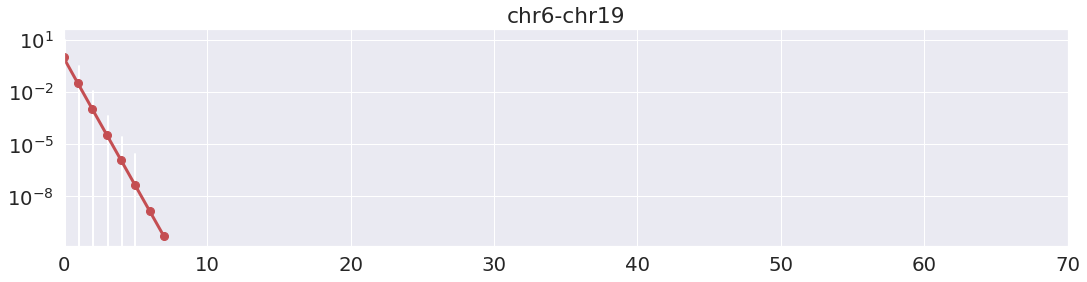

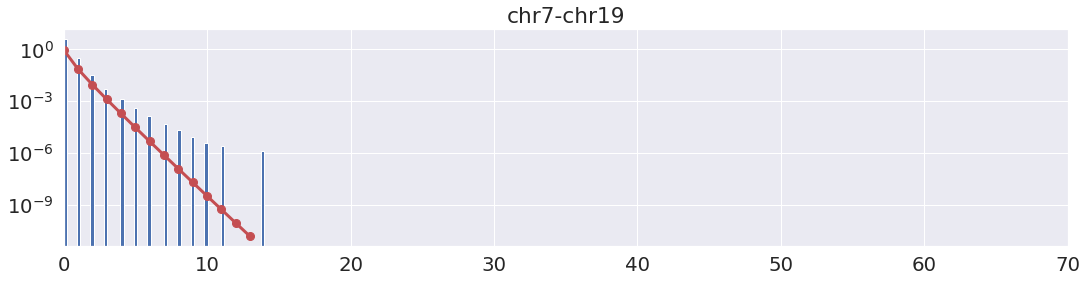

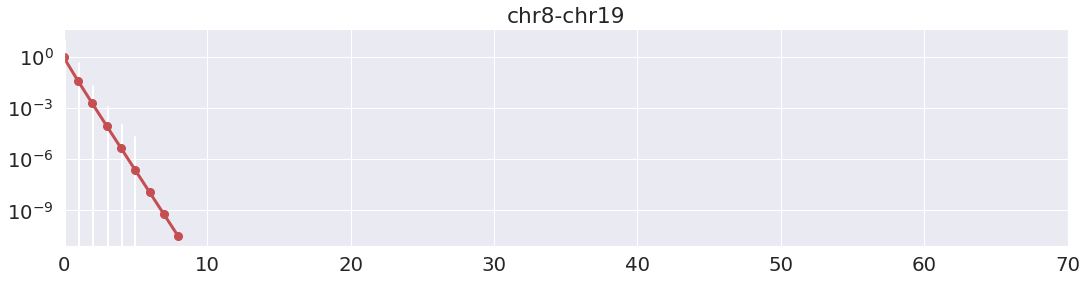

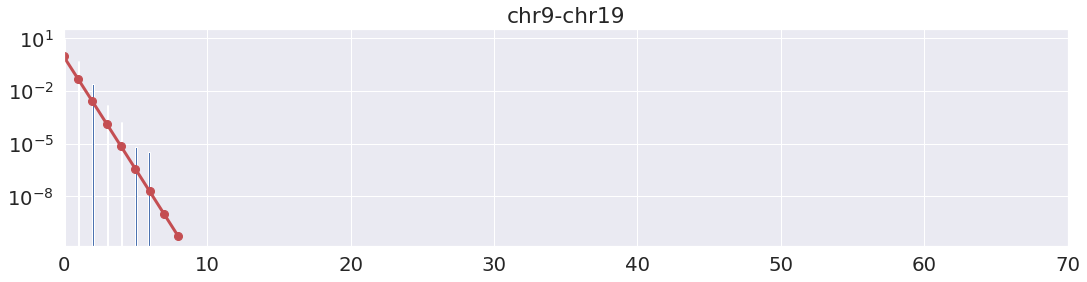

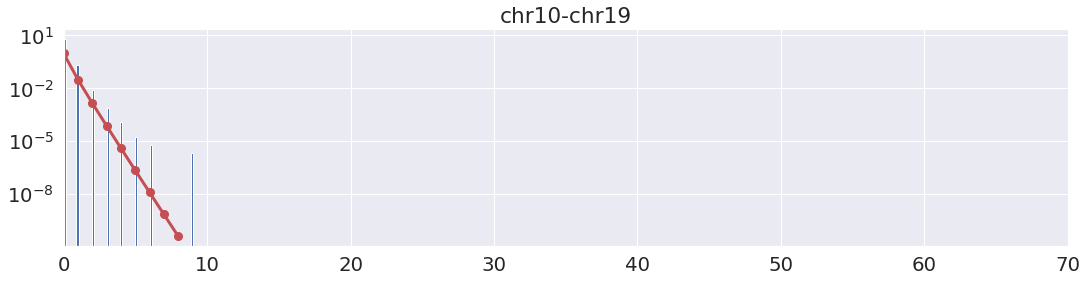

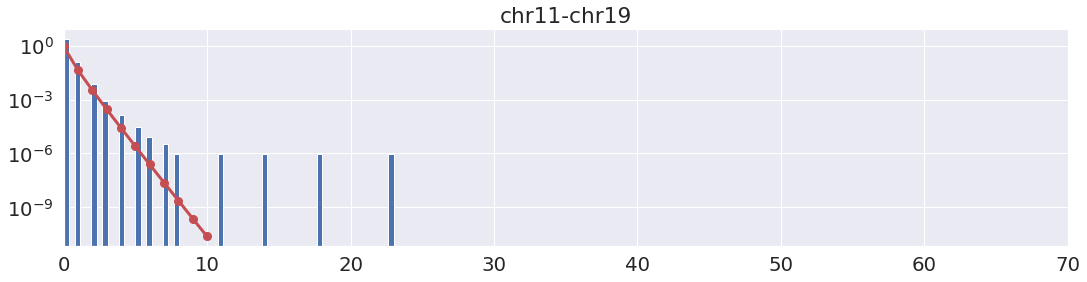

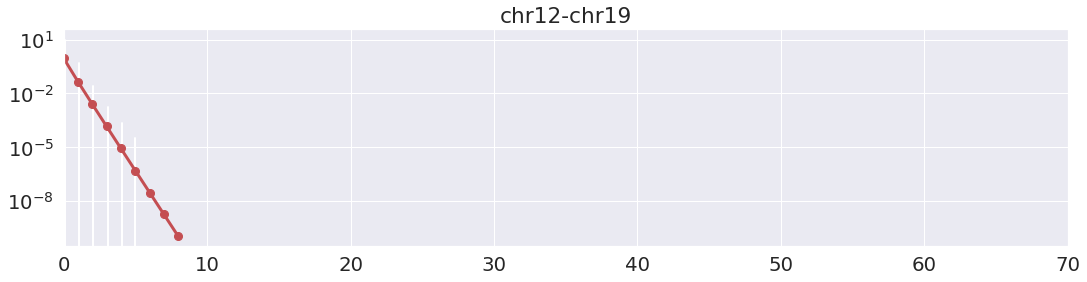

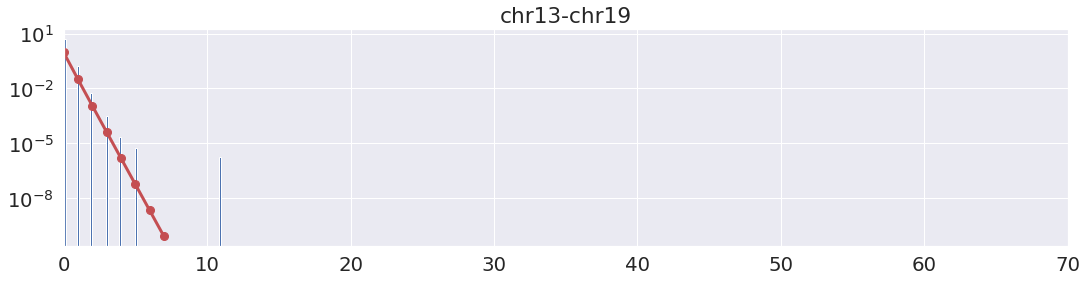

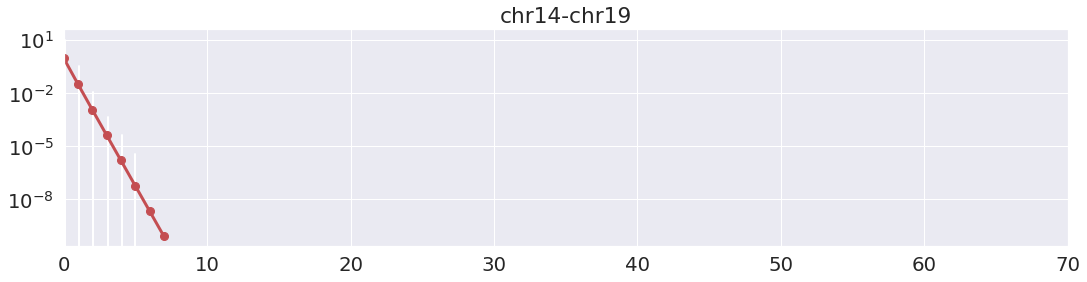

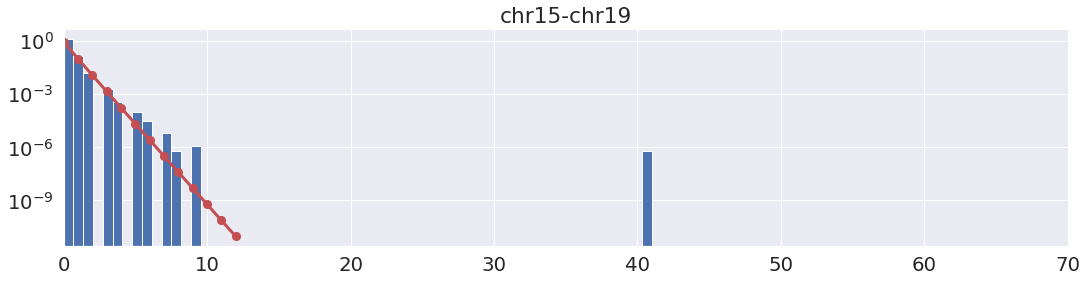

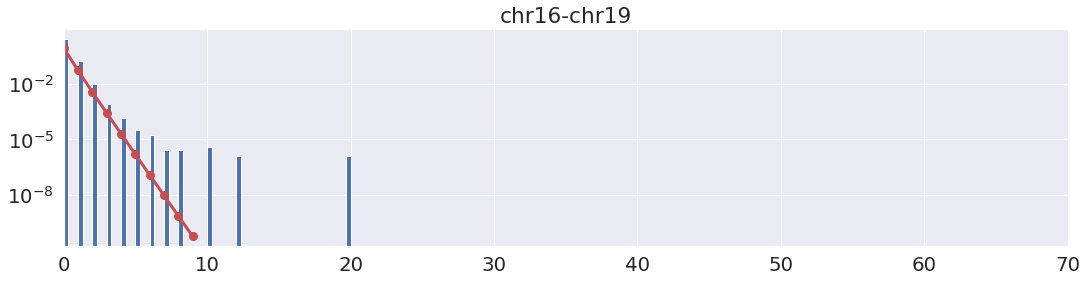

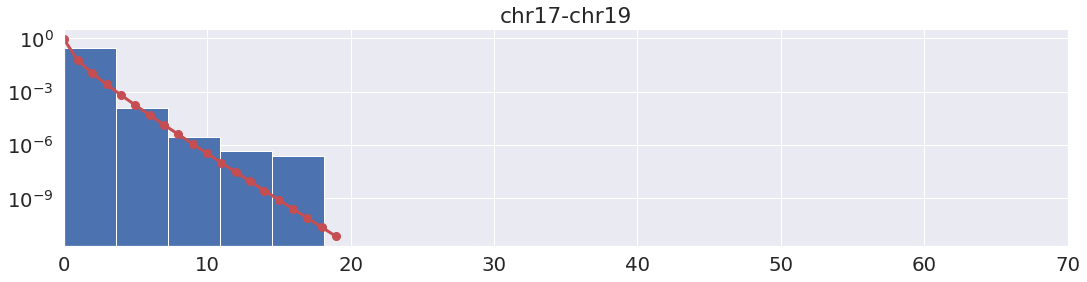

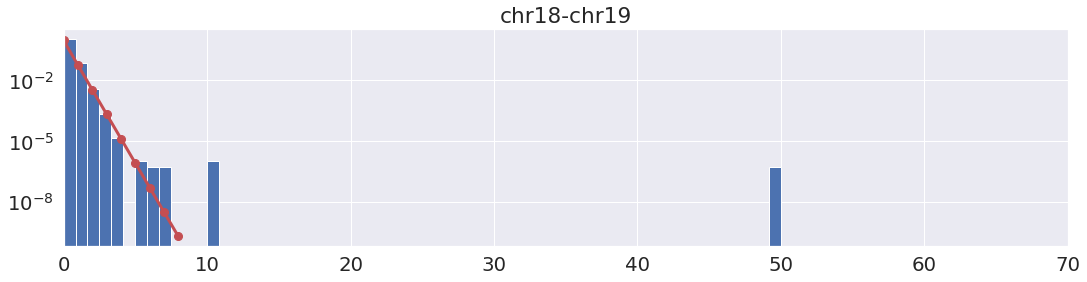

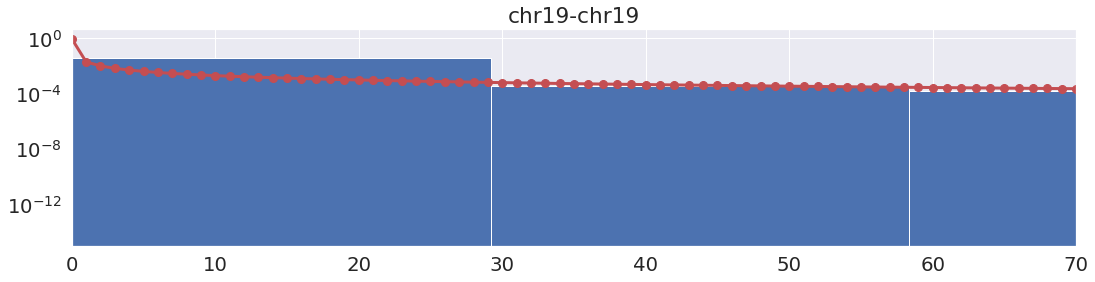

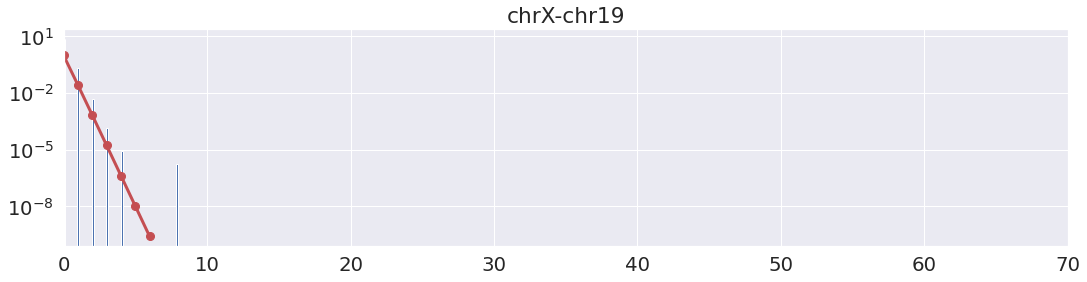

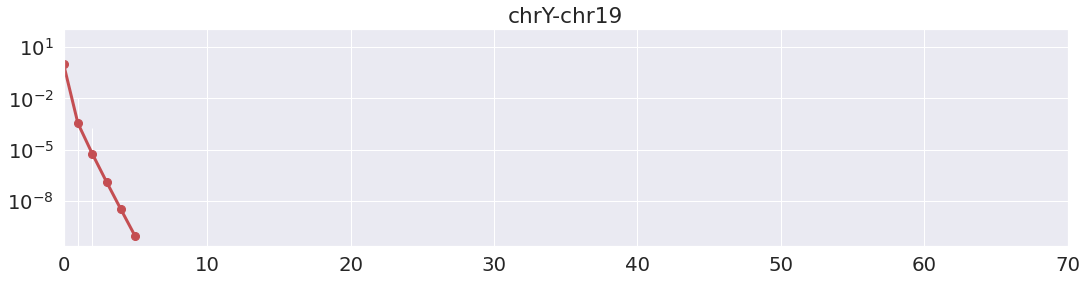

In [128]:
from scipy.stats import poisson, nbinom
for c in clr.chromnames:
    tmat = CLRS[2].matrix(balance=False).fetch(c, 'chr19')
    track = tmat.ravel()
    mu = track.mean()
    sigma = track.std(ddof=1)
    n = mu**2 / (sigma**2 - mu)
    p = mu / sigma ** 2
#     n = track.shape[0]
    x = np.arange(nbinom.ppf(1e-5, n, p),
                  nbinom.ppf(1 - 1e-12, n, p))

    plt.figure(figsize=(18,4))
    plt.title(f'{c}-chr19')
    plt.hist(track, bins=60, density=True)
    plt.plot(x, nbinom.pmf(x, n, p), 'r', marker='o', lw=3, ms=8, label='nbinom pmf')
    plt.yscale('log')
    plt.xlim([0, 70])
    plt.show()


In [67]:
trans_data['old']

,region1,region2,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr1,chr2,13338780,469878.0,66.441209,0.035226,0.000005
1,chr1,chr3,11852022,217222.0,35.067008,0.018328,0.000003
2,chr1,chr4,11209926,294223.0,42.830725,0.026247,0.000004
3,chr1,chr5,10965318,383857.0,55.024774,0.035006,0.000005
4,chr1,chr6,11057046,342354.0,51.844144,0.030963,0.000005
...,...,...,...,...,...,...,...
205,chr18,chrX,5043589,99504.0,20.373981,0.019729,0.000004
206,chr18,chrY,291749,494.0,1.292327,0.001693,0.000004
207,chr19,chrX,3294067,114535.0,22.351793,0.034770,0.000007
208,chr19,chrY,190547,745.0,2.050528,0.003910,0.000011


In [313]:
div

Name,4933424G06RIK,4933424G06RIK,OLFR1261,FBXO3,FBXO3,1110003F10RIK,GIMAP7,MYO15,MYO15,ASGR1,PFN1,FBXW17,MRPS18B
Name,,,,,,,,,,,,,
4933424G06RIK,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-18.270191,0.0,17.637469
4933424G06RIK,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
OLFR1261,0.000000,0.0,0.000000,0.000000,0.0,-17.409762,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
FBXO3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.228593
FBXO3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1110003F10RIK,0.000000,0.0,-17.409762,0.000000,0.0,0.000000,0.0,0.000000,16.897458,0.000000,0.000000,0.0,0.000000
GIMAP7,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
MYO15,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,-1.164464,-1.820080,0.0,0.000000
MYO15,0.000000,0.0,0.000000,0.000000,0.0,16.897458,0.0,0.000000,0.000000,0.000000,0.049895,0.0,-16.882454


In [316]:
s1 = pd.read_csv('subdata/BA_loops_genes.csv',index_col=0)
s2 = pd.read_csv('subdata/AB_loops_genes.csv',index_col=0)

In [334]:
s = pd.concat([s1, s2]).dropna(0)
s = s[~s['gene'].isin(['GALNTL6', 'APOOL', 'GALNT7', 'TENM1'])]

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """Entry point for launching an IPython kernel.


(0.19424350072868268, 0.398831971887944)

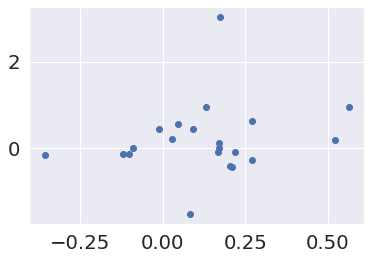

In [335]:
from scipy.stats import pearsonr
plt.scatter(s['log2fc_neur'], s['log2fc_noneur'])
pearsonr(s['log2fc_neur'], s['log2fc_noneur'])